<a href="https://colab.research.google.com/github/10844110/Colab/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, torchvision
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: Tesla T4


In [2]:
# Imports + 超參數 + DataLoader
import time, torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
test_batch_size = 1000
epochs = 50
learning_rate = 0.01
momentum = 0.5
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,
                          num_workers=2, pin_memory=torch.cuda.is_available())

print("Using device:", device)
print("Train size:", len(train_dataset), "| Test size:", len(test_dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]

Using device: cuda
Train size: 60000 | Test size: 10000


In [3]:
class FFNN(nn.Module):
    def __init__(self, in_features=28*28, hidden=100, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden)
        self.fc2 = nn.Linear(hidden, out_features)

    def forward(self, x):
        x = torch.flatten(x, 1)        # [B, 1, 28, 28] -> [B, 784]
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)   # for NLLLoss
        return x

model = FFNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.NLLLoss()
print(model)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * data.size(0)
    return epoch_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0.0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        out = model(data)
        loss = criterion(out, target)
        total_loss += loss.item() * data.size(0)
        pred = out.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    return total_loss/len(loader.dataset), correct/len(loader.dataset)

FFNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


Epoch 01/50 | train_loss=0.4523
Epoch 05/50 | train_loss=0.1372
Epoch 10/50 | train_loss=0.0782
Epoch 15/50 | train_loss=0.0539
Epoch 20/50 | train_loss=0.0396
Epoch 25/50 | train_loss=0.0304
Epoch 30/50 | train_loss=0.0236
Epoch 35/50 | train_loss=0.0186
Epoch 40/50 | train_loss=0.0149
Epoch 45/50 | train_loss=0.0121
Epoch 50/50 | train_loss=0.0100
Training finished on cuda in 590.53s


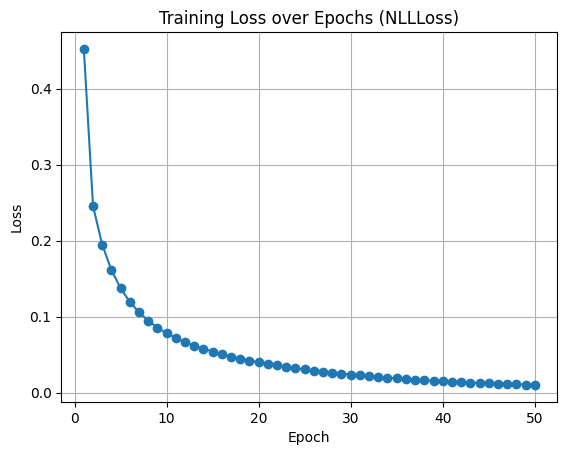

Test Loss: 0.0689
Test Accuracy: 97.92%


In [4]:
# 訓練
train_losses = []
t0 = time.perf_counter()
for epoch in range(1, epochs+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(tr_loss)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{epochs} | train_loss={tr_loss:.4f}")
print(f"Training finished on {device} in {time.perf_counter()-t0:.2f}s")

# 畫訓練損失
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o")
plt.title("Training Loss over Epochs (NLLLoss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 測試集評估
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

              precision    recall  f1-score   support

           0     0.9798    0.9878    0.9837       980
           1     0.9912    0.9903    0.9907      1135
           2     0.9786    0.9767    0.9777      1032
           3     0.9724    0.9772    0.9748      1010
           4     0.9767    0.9807    0.9787       982
           5     0.9818    0.9697    0.9757       892
           6     0.9832    0.9770    0.9801       958
           7     0.9843    0.9767    0.9805      1028
           8     0.9627    0.9805    0.9715       974
           9     0.9800    0.9732    0.9766      1009

    accuracy                         0.9792     10000
   macro avg     0.9791    0.9790    0.9790     10000
weighted avg     0.9792    0.9792    0.9792     10000



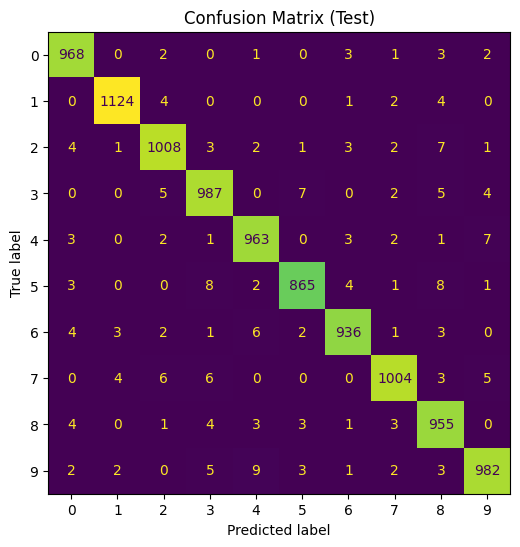

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import matplotlib.pyplot as plt

# 蒐集測試集所有預測
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        out = model(data)
        preds = out.argmax(1).cpu()
        all_preds.append(preds)
        all_targets.append(target)

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()

# 文字報告（precision/recall/F1）
print(classification_report(y_true, y_pred, digits=4))

# 混淆矩陣圖
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.show()


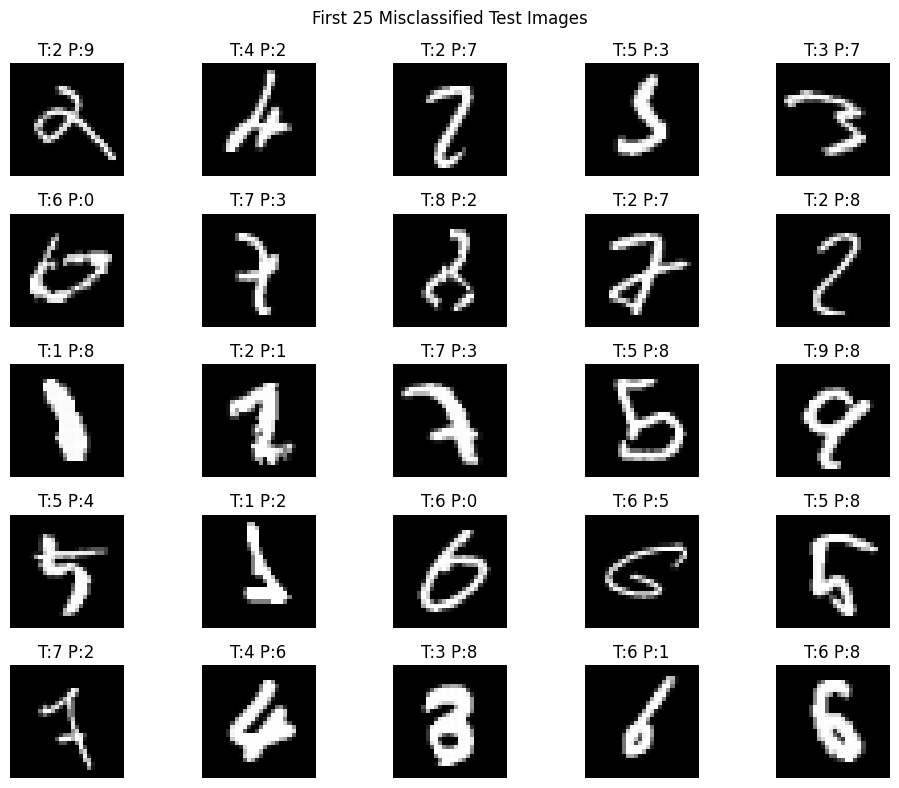

In [6]:
import math
import matplotlib.pyplot as plt
import torch

wrong_imgs, wrong_true, wrong_pred = [], [], []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        out = model(data.to(device))
        preds = out.argmax(1).cpu()
        mismatch = preds != target
        if mismatch.any():
            wrong_imgs.append(data[mismatch])
            wrong_true.append(target[mismatch])
            wrong_pred.append(preds[mismatch])
        if sum(len(x) for x in wrong_imgs) >= 25:
            break

n = 25
imgs = torch.cat(wrong_imgs)[:n]
trues = torch.cat(wrong_true)[:n]
preds = torch.cat(wrong_pred)[:n]

cols = 5
rows = math.ceil(n/cols)
plt.figure(figsize=(10,8))
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i][0], cmap="gray")
    plt.axis("off")
    plt.title(f"T:{trues[i].item()} P:{preds[i].item()}")
plt.suptitle("First 25 Misclassified Test Images")
plt.tight_layout()
plt.show()


In [7]:
import time
import torch
import torch.optim as optim

def quick_train_time(dev, epochs=5):
    m = FFNN().to(dev)
    opt = optim.SGD(m.parameters(), lr=learning_rate, momentum=momentum)
    t0 = time.perf_counter()
    for _ in range(epochs):
        _ = train_one_epoch(m, train_loader, opt, criterion, dev)
    return time.perf_counter() - t0

cpu_t = quick_train_time(torch.device("cpu"), epochs=5)
gpu_t = quick_train_time(torch.device("cuda"), epochs=5) if torch.cuda.is_available() else None
print(f"CPU (5 epochs): {cpu_t:.2f}s")
if gpu_t is not None:
    print(f"GPU (5 epochs): {gpu_t:.2f}s")


CPU (5 epochs): 58.35s
GPU (5 epochs): 59.87s


Saved: training_loss.png
Saved: mnist_ffnn.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

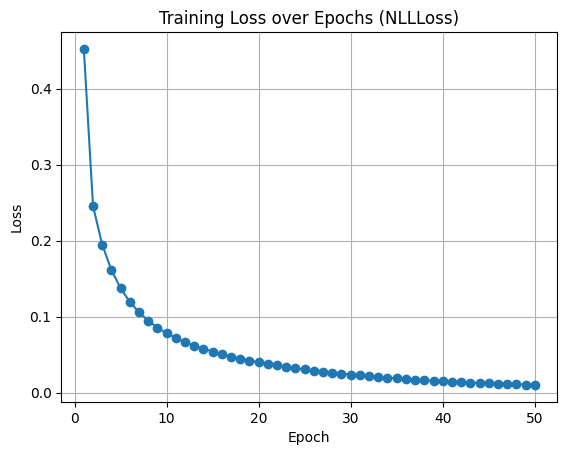

In [8]:
# 存訓練曲線
fig_path = "training_loss.png"
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o")
plt.title("Training Loss over Epochs (NLLLoss)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
plt.savefig(fig_path, dpi=150, bbox_inches="tight")
print("Saved:", fig_path)

# 存模型權重
torch.save(model.state_dict(), "mnist_ffnn.pt")
print("Saved: mnist_ffnn.pt")

#（Colab 直接下載）
from google.colab import files
files.download(fig_path)
files.download("mnist_ffnn.pt")


We trained a feedforward neural network (784–100–10, ReLU, log_softmax) on MNIST using NLLLoss and SGD (lr=0.01, momentum=0.5) for 50 epochs with standard normalization. The model achieved 97.92% test accuracy with a test loss of 0.0689. Training on a T4 GPU took about 590 s. We include the training loss curve, confusion matrix, and representative misclassified samples.